In [37]:
# !pip install transformers
## Transformers
from transformers import TFDistilBertModel, DistilBertConfig

## Tensorflow
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (Input, Dense, Dropout, Conv1D, 
                                     BatchNormalization, GlobalMaxPooling1D, 
                                     GlobalAveragePooling1D, Concatenate, 
                                     MaxPooling1D, AveragePooling1D, 
                                     Flatten, Add)
from tensorflow.keras.regularizers import l2

## Utilities
from OneCycleScheduler import *
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pickle

### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## Check GPU properties
!nvidia-smi

Fri Oct 23 13:08:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Load Data

In [4]:
f = open('/content/preprocessed.pkl','rb')
train, valid = pickle.load(f)

## Sample subset of train for testing
# train = train.sample(frac = 0.2)
# valid = valid.sample(frac = 0.2)

labels = train.columns[2:]
ys_train = train[labels]
ys_valid = valid[labels]

## COMBINE TOXIC CATEGORIES
y_train = ys_train.sum(axis=1)
y_valid = ys_valid.sum(axis=1)
y_train.loc[y_train>1] = 1
y_valid.loc[y_valid>1] = 1

### Build Tokenizer

In [5]:
## Load pretrained Distil Bert Tokenizer
from transformers import DistilBertTokenizer
distil_bert = 'distilbert-base-uncased' # pre-trained model
tokenizer = DistilBertTokenizer.from_pretrained(distil_bert, do_lower_case=True, add_special_tokens=True,
                                                max_length=128, pad_to_max_length=True)

In [6]:
## Tokenizer function
def tokenize(sentences, tokenizer, max_length = 128):
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, 
                                    add_special_tokens=True, 
                                    max_length = max_length, 
                                    pad_to_max_length=True, 
                                    return_attention_mask=True, 
                                    return_token_type_ids=True, 
                                    truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')

In [7]:
## Tokenize all
train_ids, train_masks, train_segs = tokenize(train['comment_text'], tokenizer)
valid_ids, valid_masks, valid_segs = tokenize(valid['comment_text'], tokenizer)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [8]:
train_ids.shape, train_masks.shape, train_segs.shape

((106912, 128), (106912, 128), (106912, 128))

## Model 1

In [10]:
def build_model():
    # Configure transformer model
    config = DistilBertConfig(dropout = 0.2, attention_dropout = 0.2)
    config.output_hidden_states = False
    transformer_model = TFDistilBertModel.from_pretrained(distil_bert, config = config)

    # Inputs
    input_ids = Input(shape=(128,), name='input_token', dtype='int32')
    input_masks_ids = Input(shape=(128,), name='masked_token', dtype='int32')

    # Transformer layer
    X = transformer_model(input_ids, attention_mask=input_masks_ids)[0]

    ## Keras Convolutional FIlters (4 prallel filters)
    X_2 = Conv1D(filters=50,kernel_size=2,padding='same',activation='relu', name = 'Conv2_b1')(X)
    X_4 = Conv1D(filters=50,kernel_size=4,padding='same',activation='relu', name = 'Conv4_b1')(X)
    X_6 = Conv1D(filters=50,kernel_size=6,padding='same',activation='relu', name = 'Conv6_b1')(X)
    X = Concatenate(axis=-1, name = 'cat_b1')([X_2, X_4, X_6]) 
    X = BatchNormalization(name = 'batchnorm_b1')(X)
    X_2 = Conv1D(filters=50,kernel_size=2,strides = 2, padding='same',activation='relu', name = 'Conv2_b2')(X)
    X_4 = Conv1D(filters=50,kernel_size=4,strides = 2, padding='same',activation='relu', name = 'Conv4_b2')(X)
    X_6 = Conv1D(filters=50,kernel_size=6,strides = 2, padding='same',activation='relu', name = 'Conv6_b2')(X)
    X = Concatenate(axis=-1, name = 'cat_b2')([X_2, X_4, X_6]) 
    X = BatchNormalization(name = 'batchnorm_b2')(X)
    X_2 = Conv1D(filters=50,kernel_size=2,strides = 2, padding='same',activation='relu', name = 'Conv2_b3')(X)
    X_4 = Conv1D(filters=50,kernel_size=4,strides = 2, padding='same',activation='relu', name = 'Conv4_b3')(X)
    X_6 = Conv1D(filters=50,kernel_size=6,strides = 2, padding='same',activation='relu', name = 'Conv6_b3')(X)
    X = Concatenate(axis=-1, name='cat_b3')([X_2, X_4, X_6]) 
    X = BatchNormalization(name = 'batchnorm_b3')(X)
    X_2 = Conv1D(filters=50,kernel_size=2,strides = 2, padding='same',activation='relu', name = 'Conv2_b4')(X)
    X_4 = Conv1D(filters=50,kernel_size=4,strides = 2, padding='same',activation='relu', name = 'Conv4_b4')(X)
    X_6 = Conv1D(filters=50,kernel_size=6,strides = 2, padding='same',activation='relu', name = 'Conv6_b4')(X)
    X = Concatenate(axis=-1, name= 'cat_b4')([X_2, X_4, X_6]) 
    X = BatchNormalization(name = 'batchnorm_b4')(X)
    X_Max = GlobalMaxPooling1D()(X)
    X_Avg = GlobalAveragePooling1D()(X)
    X = Concatenate(axis=-1)([X_Max,X_Avg])
    X = Dense(100, activation = 'relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(1, activation='sigmoid')(X)
    model = tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)

    # Freeze transformer layers
    for layer in model.layers[:3]:
        layer.trainable = False
    return model

In [ ]:
model = build_model()
print(model.summary())

In [ ]:
bs = 5 # batch size

model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics=['acc'])

lr_finder = LRFinder(max_steps=100) # setup lrfinder. See document for max_lr and min_lr

_ = model.fit(x = [train_ids, train_masks],
              y = y_train,
              batch_size=bs,
              steps_per_epoch=100,
              callbacks=[lr_finder])

100/100 [==============================] - 2s 24ms/step - loss: 3544.4717 - acc: 0.5880


(-0.02, 0.01)

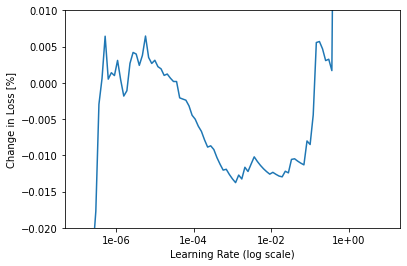

In [ ]:
fig, ax = lr_finder.plot_changes()
ax.set_ylim([-0.02,0.01])
# 1e-5 seems good

In [20]:
## Build model
model = build_model()

## Params
epochs = 20
steps_per_epoch = np.floor(len(train_ids)/bs)

## Define Learning scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Define early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      mode='min', 
                                      min_delta = 0.0001, 
                                      patience = 5,
                                      restore_best_weights=True)
## Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss='binary_crossentropy',
              metrics='acc')

## Fit model
history = model.fit(x = [train_ids, train_masks],
                    y = y_train,
                    batch_size=bs,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_split = 0.05,
                    callbacks=[lr_scheduler, es]) # add scheduler as callback

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/20
21382/21382 [==============================] - 497s 23ms/step - loss: 0.1583 - acc: 0.9438 - val_loss: 0.1170 - val_acc: 0.9607
Epoch 2/20
21382/21382 [==============================] - 494s 23ms/step - loss: 0.1274 - acc: 0.9544 - val_loss: 0.1099 - val_acc: 0.9628
Epoch 3/20
21382/21382 [==============================] - 495s 23ms/step - loss: 0.1142 - acc: 0.9588 - val_loss: 0.1239 - val_acc: 0.9575
Epoch 4/20
21382/21382 [==============================] - 496s 23ms/step - loss: 0.1068 - acc: 0.9609 - val_loss: 0.1093 - val_acc: 0.9641
Epoch 5/20
21382/21382 [==============================] - 498s 23ms/step - loss: 0.1028 - acc: 0.9617 - val_loss: 0.1085 - val_acc: 0.9660
Epoch 6/20
21382/21382 [==============================] - 498s 23ms/step - loss: 0.0946 - acc: 0.9643 - val_loss: 0.1090 - val_acc: 0.9620
Epoch 7/20
21382/21382 [==============================] - 497s 23ms/step - loss: 0.0904 - acc: 0.9660 - val_loss: 0.1038 - val_acc: 0.9667
Epoch 8/20
21382/21382 [===

In [21]:
## Get predictions
preds = model.predict([valid_ids, valid_masks], batch_size=5)
preds_t = preds
preds_t[preds_t<=0.5] = 0
preds_t[preds_t>0.5] = 1

In [22]:
## Print results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

i_preds = preds_t
i_true = y_valid

# Evaluate predictions
acc, prec, recall, f1 = (accuracy_score(i_true, i_preds), 
                        precision_score(i_true, i_preds), 
                        recall_score(i_true, i_preds), 
                        f1_score(i_true, i_preds))

# print results
print('Results for {0} comments: Accuracy - {1:.2f}; Precision - {2:.2f}; Recall - {3:.2f}; F1 - {4:.2f}'.format(
                                'Toxic_Combined', 
                                acc, 
                                prec, 
                                recall,
                                f1))

Results for Toxic_Combined comments: Accuracy - 0.96; Precision - 0.84; Recall - 0.78; F1 - 0.81


In [23]:
model.save_weights('/content/drive/My Drive/distilbert_colab')

## Model 2: Max pooling & Skip connections to prevent overfitting

In [38]:
def build_model():
    # Configure transformer model
    config = DistilBertConfig(dropout = 0.2, attention_dropout = 0.2)
    config.output_hidden_states = False
    transformer_model = TFDistilBertModel.from_pretrained(distil_bert, config = config)

    # Inputs
    input_ids = Input(shape=(128,), name='input_token', dtype='int32')
    input_masks_ids = Input(shape=(128,), name='masked_token', dtype='int32')

    # Transformer layer
    X = transformer_model(input_ids, attention_mask=input_masks_ids)[0]

    ## Keras Convolutional FIlters (4 prallel filters)
    X_2 = Conv1D(filters=50,kernel_size=2,padding='same',activation='relu', kernel_regularizer = l2(1e-4), name = 'Conv2_b1')(X)
    X_4 = Conv1D(filters=50,kernel_size=4,padding='same',activation='relu', kernel_regularizer = l2(1e-4), name = 'Conv4_b1')(X)
    X_6 = Conv1D(filters=50,kernel_size=6,padding='same',activation='relu', kernel_regularizer = l2(1e-4), name = 'Conv6_b1')(X)
    X = Concatenate(axis=-1, name = 'cat_b1')([X_2, X_4, X_6]) 
    X = MaxPooling1D(pool_size=2, padding='same', name='pool_b1')(X)
    X = BatchNormalization(name = 'batchnorm_b1')(X)
    X_2 = Conv1D(filters=50,kernel_size=2, padding='same',activation='relu', kernel_regularizer = l2(1e-4), name = 'Conv2_b2')(X)
    X_4 = Conv1D(filters=50,kernel_size=4, padding='same',activation='relu', kernel_regularizer = l2(1e-4), name = 'Conv4_b2')(X)
    X_6 = Conv1D(filters=50,kernel_size=6, padding='same',activation='relu', kernel_regularizer = l2(1e-4), name = 'Conv6_b2')(X)
    X = Concatenate(axis=-1, name = 'cat_b2')([X_2, X_4, X_6]) 
    X = MaxPooling1D(pool_size=2, padding='same', name='pool_b2')(X)
    X = BatchNormalization(name = 'batchnorm_b2')(X)
    X_2 = Conv1D(filters=50,kernel_size=2, padding='same',activation='relu', kernel_regularizer = l2(1e-4),name = 'Conv2_b3')(X)
    X_4 = Conv1D(filters=50,kernel_size=4, padding='same',activation='relu', kernel_regularizer = l2(1e-4),name = 'Conv4_b3')(X)
    X_6 = Conv1D(filters=50,kernel_size=6, padding='same',activation='relu', kernel_regularizer = l2(1e-4),name = 'Conv6_b3')(X)
    X = Concatenate(axis=-1, name='cat_b3')([X_2, X_4, X_6]) 
    X = MaxPooling1D(pool_size=2, padding='same', name='pool_b3')(X)
    X = BatchNormalization(name = 'batchnorm_b3')(X)
    X_2 = Conv1D(filters=50,kernel_size=2, padding='same',activation='relu', kernel_regularizer = l2(1e-4),name = 'Conv2_b4')(X)
    X_4 = Conv1D(filters=50,kernel_size=4, padding='same',activation='relu', kernel_regularizer = l2(1e-4),name = 'Conv4_b4')(X)
    X_6 = Conv1D(filters=50,kernel_size=6, padding='same',activation='relu', kernel_regularizer = l2(1e-4),name = 'Conv6_b4')(X)
    X = Concatenate(axis=-1, name= 'cat_b4')([X_2, X_4, X_6]) 
    X = MaxPooling1D(pool_size=2, padding='same', name='pool_b4')(X)
    X = BatchNormalization(name = 'batchnorm_b4')(X)
    X = Flatten()(X)
    X = Dense(100, activation = 'relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(1, activation='sigmoid')(X)
    model = tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)

    # Freeze transformer layers
    for layer in model.layers[:3]:
        layer.trainable = False
    return model

In [39]:
model = build_model()
print(model.summary())

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_5 (TFDisti ((None, 128, 768),)  66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
Conv2_b1 (Conv1D)               (None, 128, 50)      76850       tf_distil_bert_model_

### Train model

In [40]:
bs = 5 # batch size

model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics=['acc'])

lr_finder = LRFinder(max_steps=100) # setup lrfinder. See document for max_lr and min_lr

_ = model.fit(x = [train_ids, train_masks],
              y = y_train,
              batch_size=bs,
              steps_per_epoch=100,
              callbacks=[lr_finder])

100/100 [==============================] - 2s 24ms/step - loss: 150367.4375 - acc: 0.7240


(-0.02, 0.01)

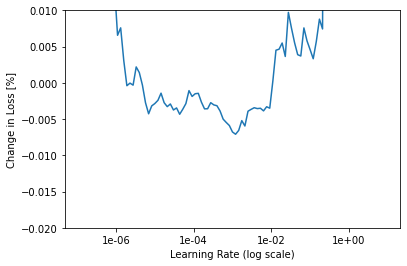

In [41]:
fig, ax = lr_finder.plot_changes()
ax.set_ylim([-0.02,0.01])
# 1e-3 seems good

In [42]:
## Build model
model = build_model()

## Params
epochs = 20
steps_per_epoch = np.floor(len(train_ids)/bs)

## Define Learning scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Define early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      mode='min', 
                                      min_delta = 0.0001, 
                                      patience = 5,
                                      restore_best_weights=True)
## Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss='binary_crossentropy',
              metrics='acc')

## Fit model
history = model.fit(x = [train_ids, train_masks],
                    y = y_train,
                    batch_size=bs,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_split = 0.05,
                    callbacks=[lr_scheduler, es]) # add scheduler as callback

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/20
21382/21382 [==============================] - 517s 24ms/step - loss: 0.2425 - acc: 0.9375 - val_loss: 0.1899 - val_acc: 0.9433
Epoch 2/20
21382/21382 [==============================] - 511s 24ms/step - loss: 0.1642 - acc: 0.9519 - val_loss: 0.1330 - val_acc: 0.9581
Epoch 3/20
21382/21382 [==============================] - 513s 24ms/step - loss: 0.1469 - acc: 0.9547 - val_loss: 0.1223 - val_acc: 0.9628
Epoch 4/20
21382/21382 [==============================] - 513s 24ms/step - loss: 0.1393 - acc: 0.9558 - val_loss: 0.2310 - val_acc: 0.9598
Epoch 5/20
21382/21382 [==============================] - 514s 24ms/step - loss: 0.1367 - acc: 0.9564 - val_loss: 0.1368 - val_acc: 0.9607
Epoch 6/20
21382/21382 [==============================] - 514s 24ms/step - loss: 0.1301 - acc: 0.9580 - val_loss: 0.1238 - val_acc: 0.9590
Epoch 7/20
21382/21382 [==============================] - 517s 24ms/step - loss: 0.1291 - acc: 0.9582 - val_loss: 0.1150 - val_acc: 0.9602
Epoch 8/20
21382/21382 [===

In [43]:
## Get predictions
preds = model.predict([valid_ids, valid_masks], batch_size=5)
preds_t = preds
preds_t[preds_t<=0.5] = 0
preds_t[preds_t>0.5] = 1

In [44]:
## Print results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

i_preds = preds_t
i_true = y_valid

# Evaluate predictions
acc, prec, recall, f1 = (accuracy_score(i_true, i_preds), 
                        precision_score(i_true, i_preds), 
                        recall_score(i_true, i_preds), 
                        f1_score(i_true, i_preds))

# print results
print('Results for {0} comments: Accuracy - {1:.2f}; Precision - {2:.2f}; Recall - {3:.2f}; F1 - {4:.2f}'.format(
                                'Toxic_Combined', 
                                acc, 
                                prec, 
                                recall,
                                f1))

Results for Toxic_Combined comments: Accuracy - 0.96; Precision - 0.86; Recall - 0.75; F1 - 0.80


In [45]:
model.save_weights('/content/drive/My Drive/distilbert_colab_2')

### Let's train a bit more

In [46]:
bs = 5 # batch size

model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics=['acc'])

lr_finder = LRFinder(max_steps=100) # setup lrfinder. See document for max_lr and min_lr

_ = model.fit(x = [train_ids, train_masks],
              y = y_train,
              batch_size=bs,
              steps_per_epoch=100,
              callbacks=[lr_finder])

100/100 [==============================] - 2s 25ms/step - loss: 85506.4375 - acc: 0.9240


(-0.02, 0.01)

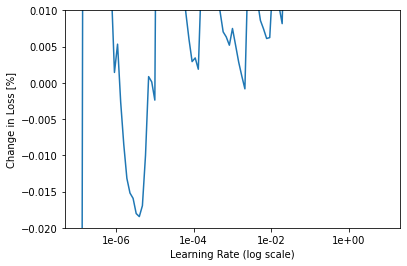

In [47]:
fig, ax = lr_finder.plot_changes()
ax.set_ylim([-0.02,0.01])
# 5e-6 seems good

In [48]:
## Load model weights from before lr_finder
model.load_weights('/content/drive/My Drive/distilbert_colab_2')

## Params
epochs = 20
steps_per_epoch = np.floor(len(train_ids)/bs)

## Define Learning scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Define early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      mode='min', 
                                      min_delta = 0.0001, 
                                      patience = 5,
                                      restore_best_weights=True)
## Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6), 
              loss='binary_crossentropy',
              metrics='acc')

## Fit model
history = model.fit(x = [train_ids, train_masks],
                    y = y_train,
                    batch_size=bs,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_split = 0.05,
                    callbacks=[lr_scheduler, es]) # add scheduler as callback

Epoch 1/20
21382/21382 [==============================] - 533s 25ms/step - loss: 0.1059 - acc: 0.9631 - val_loss: 0.1069 - val_acc: 0.9656
Epoch 2/20
21382/21382 [==============================] - 522s 24ms/step - loss: 0.1059 - acc: 0.9633 - val_loss: 0.1062 - val_acc: 0.9656
Epoch 3/20
21382/21382 [==============================] - 518s 24ms/step - loss: 0.1032 - acc: 0.9638 - val_loss: 0.1058 - val_acc: 0.9658
Epoch 4/20
21382/21382 [==============================] - 515s 24ms/step - loss: 0.1047 - acc: 0.9638 - val_loss: 0.1062 - val_acc: 0.9648
Epoch 5/20
21382/21382 [==============================] - 514s 24ms/step - loss: 0.1047 - acc: 0.9640 - val_loss: 0.1062 - val_acc: 0.9650
Epoch 6/20
21382/21382 [==============================] - 514s 24ms/step - loss: 0.1033 - acc: 0.9639 - val_loss: 0.1064 - val_acc: 0.9650
Epoch 7/20
21382/21382 [==============================] - 513s 24ms/step - loss: 0.1047 - acc: 0.9638 - val_loss: 0.1065 - val_acc: 0.9646
Epoch 8/20
21382/21382 [===

In [49]:
## Get predictions
preds = model.predict([valid_ids, valid_masks], batch_size=5)
preds_t = preds
preds_t[preds_t<=0.5] = 0
preds_t[preds_t>0.5] = 1

In [50]:
## Print results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

i_preds = preds_t
i_true = y_valid

# Evaluate predictions
acc, prec, recall, f1 = (accuracy_score(i_true, i_preds), 
                        precision_score(i_true, i_preds), 
                        recall_score(i_true, i_preds), 
                        f1_score(i_true, i_preds))

# print results
print('Results for {0} comments: Accuracy - {1:.2f}; Precision - {2:.2f}; Recall - {3:.2f}; F1 - {4:.2f}'.format(
                                'Toxic_Combined', 
                                acc, 
                                prec, 
                                recall,
                                f1))

Results for Toxic_Combined comments: Accuracy - 0.96; Precision - 0.86; Recall - 0.76; F1 - 0.81


In [52]:
model.save_weights('/content/drive/My Drive/distilbert_colab_2_round2')